In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

from astropy.io import fits

In [4]:
hdul = fits.open('../data/apogee_astroNN-DR17.fits')

In [5]:
for key in hdul[1].header.keys():
    if 'TTYPE' in key:
        print(hdul[1].header[key])

APOGEE_ID
LOCATION_ID
TELESCOPE
RA_APOGEE
DEC_APOGEE
TEFF
TEFF_ERR
LOGG
LOGG_ERR
C_H
C_H_ERR
CI_H
CI_H_ERR
N_H
N_H_ERR
O_H
O_H_ERR
NA_H
NA_H_ERR
MG_H
MG_H_ERR
AL_H
AL_H_ERR
SI_H
SI_H_ERR
P_H
P_H_ERR
S_H
S_H_ERR
K_H
K_H_ERR
CA_H
CA_H_ERR
TI_H
TI_H_ERR
TIII_H
TIII_H_ERR
V_H
V_H_ERR
CR_H
CR_H_ERR
MN_H
MN_H_ERR
FE_H
FE_H_ERR
CO_H
CO_H_ERR
NI_H
NI_H_ERR
dist
dist_error
dist_model_error
nn_parallax
nn_parallax_error
nn_parallax_model_error
fakemag
fakemag_error
weighted_dist
weighted_dist_error
RA
DEC
pmra
pmra_error
ref_epoch
pmdec
pmdec_error
phot_g_mean_mag
bp_rp
g_rp
VHELIO_AVG
age
age_linear_correct
age_lowess_correct
age_total_error
age_model_error
source_id
galr
galphi
galz
galvr
galvt
galvz
galr_err
galphi_err
galz_err
galvr_err
galvt_err
galvz_err
galvr_galvt_corr
galvr_galvz_corr
galvt_galvz_corr
e
e_err
zmax
zmax_err
rperi
rperi_err
rap
rap_err
e_zmax_corr
e_rperi_corr
e_rap_corr
zmax_rperi_corr
zmax_rap_corr
rperi_rap_corr
jr
jr_err
Lz
Lz_err
jz
jz_err
jr_Lz_corr
jr_jz_corr
lz_jz

In [6]:
Lz = hdul[1].data.Lz
zmax = hdul[1].data.zmax

logFeH = hdul[1].data.FE_H
logMgH = hdul[1].data.MG_H
logMgFe = logMgH - logFeH

e_logFeH = hdul[1].data.FE_H_ERR

FeH = 10.**logFeH
MgH = 10.**logMgH
MgFe = 10.**logMgFe

age = hdul[1].data.age
# age1 = hdul[1].data.age_linear_correct
# age2 = hdul[1].data.age_lowess_correct

age_err = hdul[1].data.age_total_error

t_form = 13.813 - age

/tmp/ipykernel_33490/1407424932.py:10: RuntimeWarning: overflow encountered in power
  FeH = 10.**logFeH
/tmp/ipykernel_33490/1407424932.py:11: RuntimeWarning: overflow encountered in power
  MgH = 10.**logMgH
/tmp/ipykernel_33490/1407424932.py:12: RuntimeWarning: overflow encountered in power
  MgFe = 10.**logMgFe


In [7]:
logg = hdul[1].data.LOGG
logg_err = hdul[1].data.LOGG_ERR

In [8]:
vsun = 220
Rsun = 8
Lzsun = Rsun * vsun

Lz_diff = np.abs(Lz/Lzsun - 1)

in_SN = np.logical_and(Lz_diff < 0.05 , zmax<3)
in_SN = np.logical_and(in_SN, logg_err < 0.2)
in_SN = np.logical_and(in_SN, age_err/age < 0.2)
in_SN = np.logical_and(in_SN, logg < 3.5)
print(len(np.where(in_SN)[0]))

13069


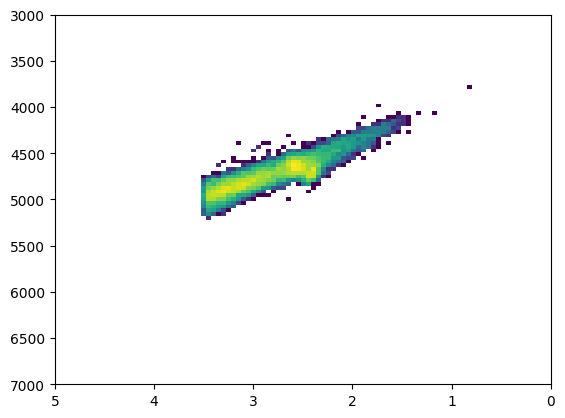

In [9]:
Teff = hdul[1].data.TEFF

xbins = np.linspace(0, 5, 100)
ybins = np.linspace(3000, 7000, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logg[in_SN], Teff[in_SN], np.full(len(logg[in_SN]), 1), 
                                                     statistic='sum', bins=[xbins, ybins])
    
plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

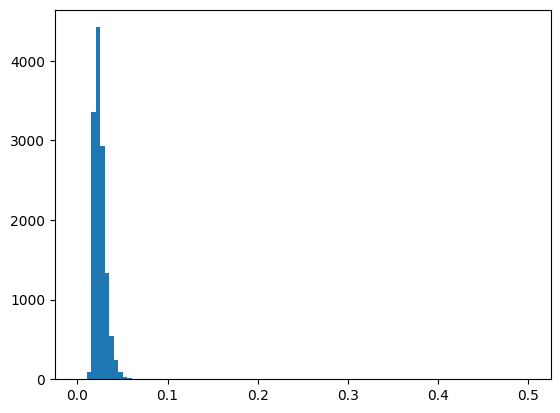

In [10]:
plt.hist(e_logFeH[in_SN], bins=np.linspace(0, 0.5, 100));

Text(0, 0.5, 'age error [Gyr]')

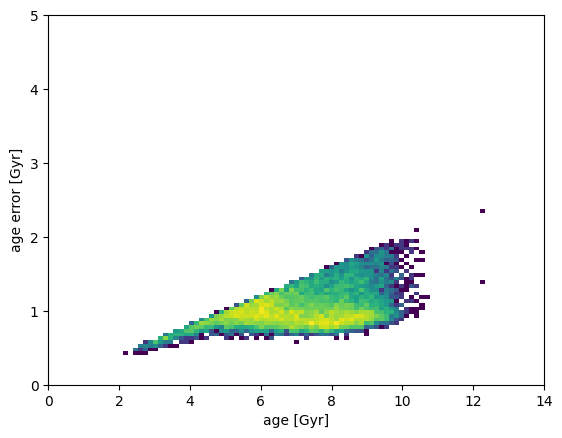

In [11]:
# plt.hist(age_err[in_SN]/age[in_SN], bins=np.linspace(0, 1, 100));

age_bins  = np.linspace(0, 14, 100)
age_err_bins = np.linspace(0, 5, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], age_err[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, age_err_bins])
# mbin, x_edge, y_edge, _ = binned_statistic_2d(age, age_err, np.full(len(age), 1), 
                                                     # statistic='sum', bins=[age_bins, age_err_bins])
    
plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

# plt.plot(aveFe, aveMgFe, c='r')

plt.xlabel('age [Gyr]')
plt.ylabel('age error [Gyr]')

# plt.plot(avet, aveMgFe)

Text(0, 0.5, '[Mg/Fe]')

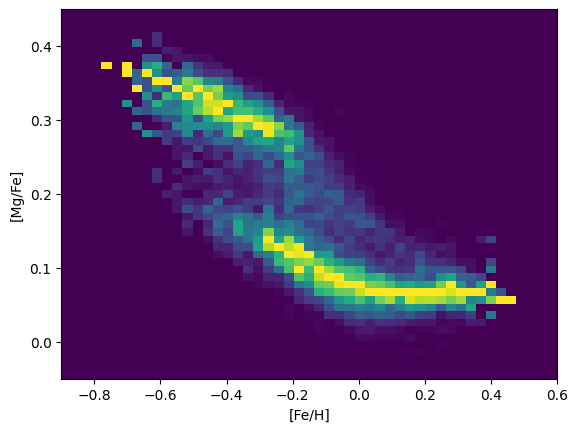

In [17]:
logFeH_bins  = np.linspace(-0.9, 0.6, 50)
logMgFe_bins = np.linspace(-0.05, 0.45, 50)

# logFeH_bins  = np.linspace(-1.5, 0.6, 50)
# logMgFe_bins = np.linspace(-0.05, 0.6, 50)

# mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     # statistic='sum', bins=[logFeH_bins, logMgFe_bins])

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[logFeH_bins, logMgFe_bins])
downstairs = np.max(mbin, axis=1)
downstairs[downstairs == 0.0] = 1e-20
mbin = (mbin.T / downstairs).T

plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
plt.xlim(logFeH_bins[0], logFeH_bins[-1])
plt.ylim(logMgFe_bins[0], logMgFe_bins[-1])
plt.gca().set_aspect('auto')

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

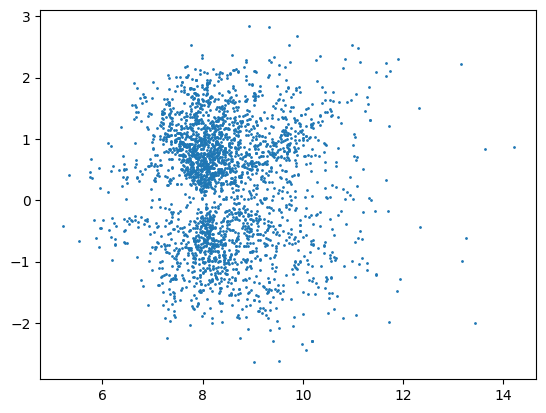

In [14]:
# spatial extent of high alpha stars
high_alpha = logMgFe > 0.22
high_alpha_in_SN = np.logical_and(high_alpha, in_SN)

galr = hdul[1].data.galr
galz = hdul[1].data.galz

plt.scatter(galr[high_alpha_in_SN], galz[high_alpha_in_SN], s=1)

Text(0, 0.5, '[Fe/H]')

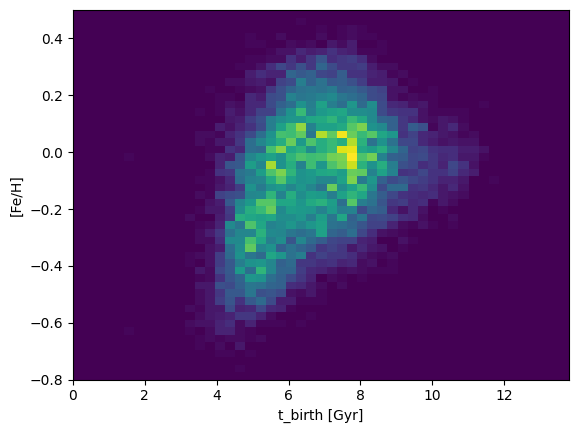

In [25]:
tbirth_bins  = np.linspace(0, 13.8, 50)
logFe_bins = np.linspace(-0.8, 0.5, 50)

# mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     # statistic='sum', bins=[logFeH_bins, logMgFe_bins])


tbirth = 13.8 - age

mbin, x_edge, y_edge, _ = binned_statistic_2d(tbirth[in_SN], logFeH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[tbirth_bins, logFe_bins])
# downstairs = np.max(mbin, axis=1)
# downstairs[downstairs == 0.0] = 1e-20
# mbin = (mbin.T / downstairs).T

plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
# plt.xlim(logFeH_bins[0], logFeH_bins[-1])
# plt.ylim(logMgFe_bins[0], logMgFe_bins[-1])
plt.gca().set_aspect('auto')

plt.xlabel('t_birth [Gyr]')
plt.ylabel('[Fe/H]')

(0.0, 100.0)


Text(0, 0.5, '[Mg/Fe]')

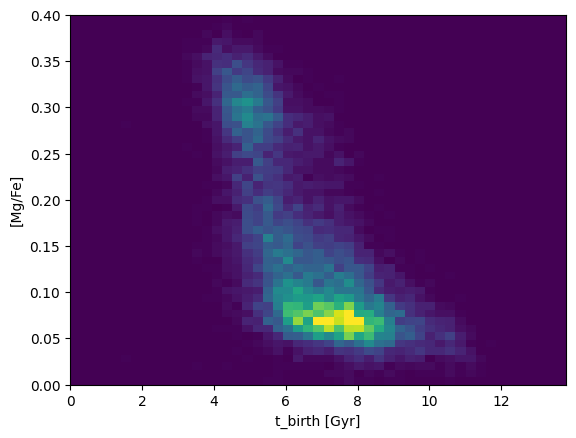

In [32]:
tbirth_bins  = np.linspace(0, 13.8, 50)
logMgFe_bins = np.linspace(0, 0.4, 50)

# mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     # statistic='sum', bins=[logFeH_bins, logMgFe_bins])


tbirth = 13.8 - age

mbin, x_edge, y_edge, _ = binned_statistic_2d(tbirth[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[tbirth_bins, logMgFe_bins])
# downstairs = np.max(mbin, axis=1)
# downstairs[downstairs == 0.0] = 1e-20
# mbin = (mbin.T / downstairs).T

im = plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               vmin=0, vmax=100)#, norm=mpl.colors.LogNorm())
# plt.xlim(logFeH_bins[0], logFeH_bins[-1])
# plt.ylim(logMgFe_bins[0], logMgFe_bins[-1])
plt.gca().set_aspect('auto')

print(im.get_clim())

plt.xlabel('t_birth [Gyr]')
plt.ylabel('[Mg/Fe]')

/tmp/ipykernel_1756409/2538932951.py:15: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T
/tmp/ipykernel_1756409/2538932951.py:22: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T
/tmp/ipykernel_1756409/2538932951.py:29: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T
/tmp/ipykernel_1756409/2538932951.py:43: RuntimeWarning: invalid value encountered in divide
  mbin = (mbin.T / np.max(mbin, axis=1)).T


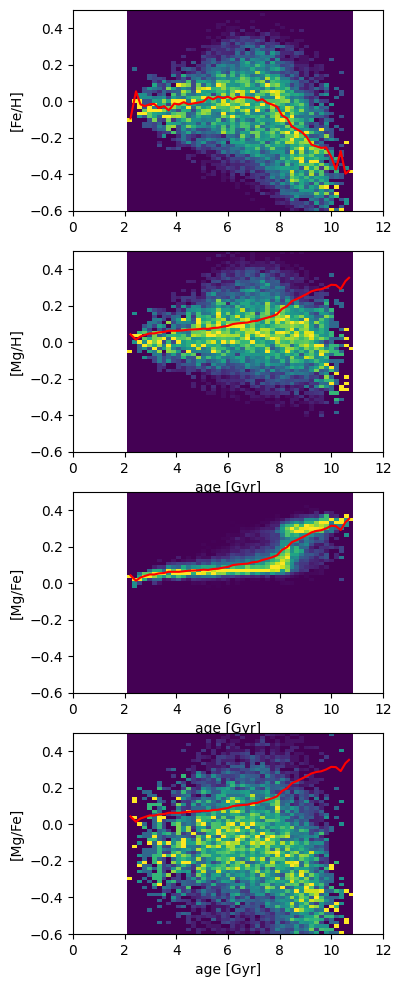

In [11]:
age_bins  = np.linspace(0, 12, 64)
logFeH_bins = np.linspace(-0.6, 0.5, 64)
logMgFe_bins = np.linspace(-0.6, 0.5, 64)

aveFe, _, _ = binned_statistic(age[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(age[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(age[in_SN], age[in_SN], bins=age_bins)
logaveFe = np.log10(aveFe)
logaveMgFe = np.log10(aveMgFe)

fig, ax = plt.subplots(4, 1, figsize=(4, 12), sharex=False)

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logFeH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logFeH_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[0].plot(aveage, logaveFe, c='r')
ax[0].set(aspect='auto', ylabel='[Fe/H]')

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[1].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/H]')
ax[1].plot(aveage, logaveMgFe, c='r')

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[2].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/Fe]')
ax[2].plot(aveage, logaveMgFe, c='r')

# logMgH_in_SN_shuffle = np.copy(logMgH[in_SN])
# np.random.shuffle(logMgH_in_SN_shuffle)
# logMgFe_fake_in_SN = logFeH[in_SN] - logMgH_in_SN_shuffle

key = np.argsort(logFeH[in_SN])
logMgFe_fake_in_SN = logFeH[in_SN] - logMgH[in_SN][key]

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgFe_fake_in_SN, np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[3].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/Fe]')
ax[3].plot(aveage, logaveMgFe, c='r')

In [12]:
logMgH_in_SN_shuffle = np.copy(logMgH[in_SN])
print(logMgH_in_SN_shuffle[:4])
np.random.shuffle(logMgH_in_SN_shuffle)
print(logMgH_in_SN_shuffle[:4])

[0.01663479 0.06471955 0.08439236 0.11208005]
[0.04197017 0.07110637 0.23200524 0.27582055]


[None, Text(0, 0.5, 'residual [Mg/Fe]'), Text(0.5, 0, 'residual [Fe/H]')]

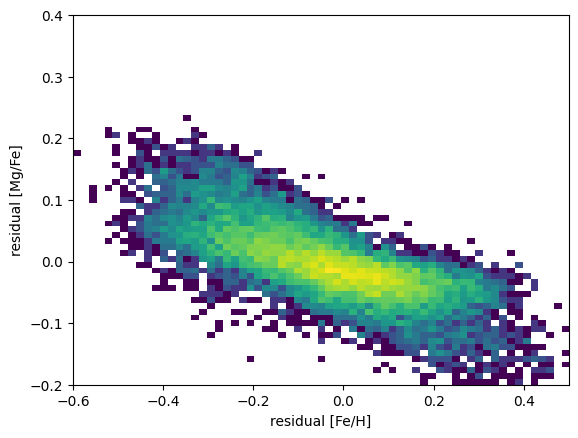

In [13]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
logFeH_bins = np.linspace(-0.6, 0.5, 64)
logMgFe_bins = np.linspace(-0.2, 0.4, 64)

aveFe, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_form[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins)
logaveFe = np.log10(aveFe)
logaveMgFe = np.log10(aveMgFe)

logaveFe_interp = interp1d(aveage, logaveFe, bounds_error=False, fill_value='extrapolate')
logaveMgFe_interp = interp1d(aveage, logaveMgFe, bounds_error=False, fill_value='extrapolate')

logaveFe_pred = logaveFe_interp(t_form)
logaveMgFe_pred = logaveMgFe_interp(t_form)

fig, ax = plt.subplots(1, 1)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN]-logaveFe_pred[in_SN], 
                                              logMgFe[in_SN]-logaveMgFe_pred[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgFe_bins])
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax.set(aspect='auto', ylabel='residual [Mg/Fe]', xlabel='residual [Fe/H]')

# mbin, x_edge, y_edge, _ = binned_statistic_2d(t_form[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
#                                                      statistic='sum', bins=[age_bins, MgFe_bins])
# ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
# ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
# ax[1].plot(aveage, aveMgFe)

[None, Text(0, 0.5, 'residual Z_Mg/Z_Fe'), Text(0.5, 0, 'residual Z_Fe')]

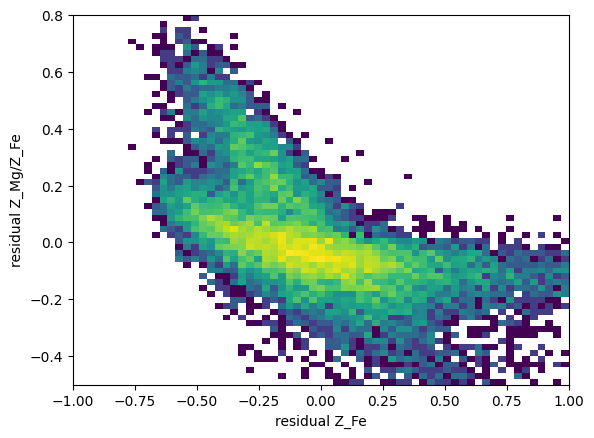

In [14]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(-1, 1, 64)
MgFe_bins = np.linspace(-0.5, 0.8, 64)

t_form = 13.813 - age

aveFe, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_form[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins)
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFe_interp = interp1d(aveage, aveFe, bounds_error=False, fill_value='extrapolate')
aveMgFe_interp = interp1d(aveage, aveMgFe, bounds_error=False, fill_value='extrapolate')

aveFe_pred = aveFe_interp(t_form)
aveMgFe_pred = aveMgFe_interp(t_form)

fig, ax = plt.subplots(1, 1)

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN]-aveFe_pred[in_SN], 
                                              MgFe[in_SN]-aveMgFe_pred[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgFe_bins])
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax.set(aspect='auto', ylabel='residual Z_Mg/Z_Fe', xlabel='residual Z_Fe')

# mbin, x_edge, y_edge, _ = binned_statistic_2d(t_form[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
#                                                      statistic='sum', bins=[age_bins, MgFe_bins])
# ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
# ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
# ax[1].plot(aveage, aveMgFe)

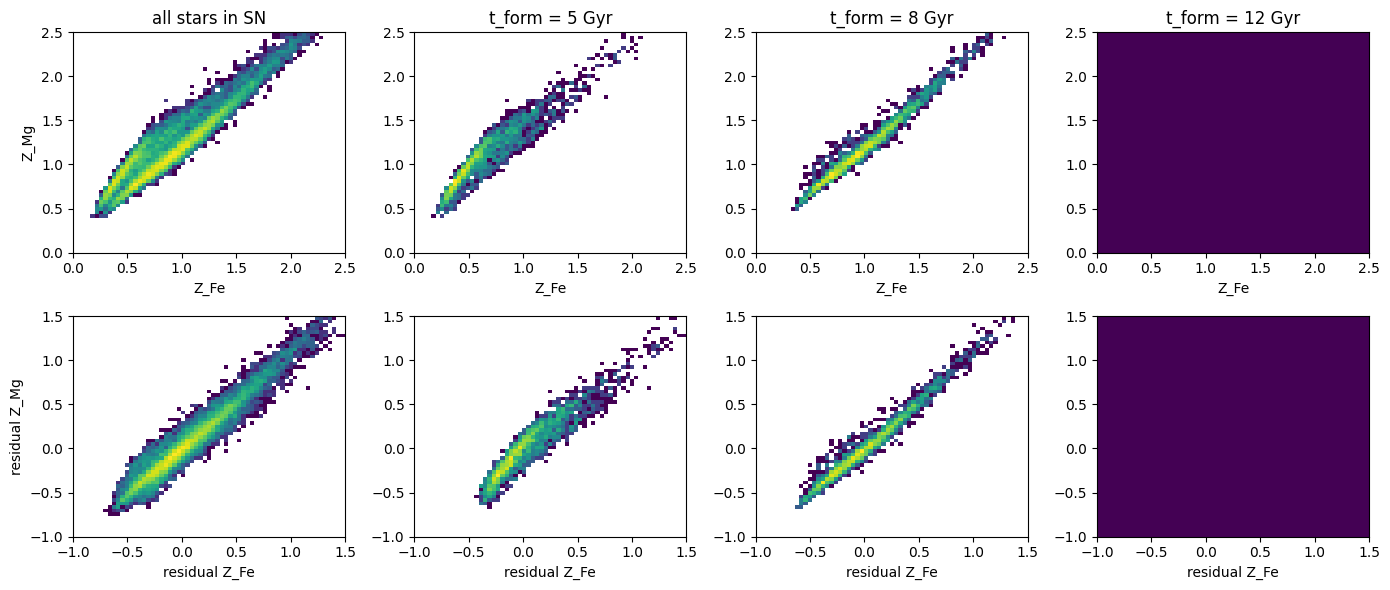

In [15]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(0, 2.5, 64)
MgH_bins = np.linspace(0, 2.5, 64)
resid_FeH_bins = np.linspace(-1, 1.5, 64)
resid_MgH_bins = np.linspace(-1, 1.5, 64)

aveFeH, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins, statistic='median')
aveMgH, _, _ = binned_statistic(t_form[in_SN], MgH[in_SN], bins=age_bins, statistic='median')
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins, statistic='median')
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFeH_interp = interp1d(aveage, aveFeH, bounds_error=False, fill_value='extrapolate')
aveMgH_interp = interp1d(aveage, aveMgH, bounds_error=False, fill_value='extrapolate')

aveFeH_pred = aveFeH_interp(t_form)
aveMgH_pred = aveMgH_interp(t_form)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))

resid_FeH = FeH - aveFeH_pred
resid_MgH = MgH - aveMgH_pred

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN], 
                                              MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][0].set(aspect='auto', ylabel='Z_Mg', xlabel='Z_Fe')
ax[0][0].set_title('all stars in SN')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[in_SN], 
                                              resid_MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][0].set(aspect='auto', ylabel='residual Z_Mg', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][1].set(aspect='auto', xlabel='Z_Fe')
ax[0][1].set_title('t_form = 5 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][1].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][2].set(aspect='auto', xlabel='Z_Fe')
ax[0][2].set_title('t_form = 8 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][2].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][3].set(aspect='auto', xlabel='Z_Fe')
ax[0][3].set_title('t_form = 12 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][3].set(aspect='auto', xlabel='residual Z_Fe')

fig.tight_layout()

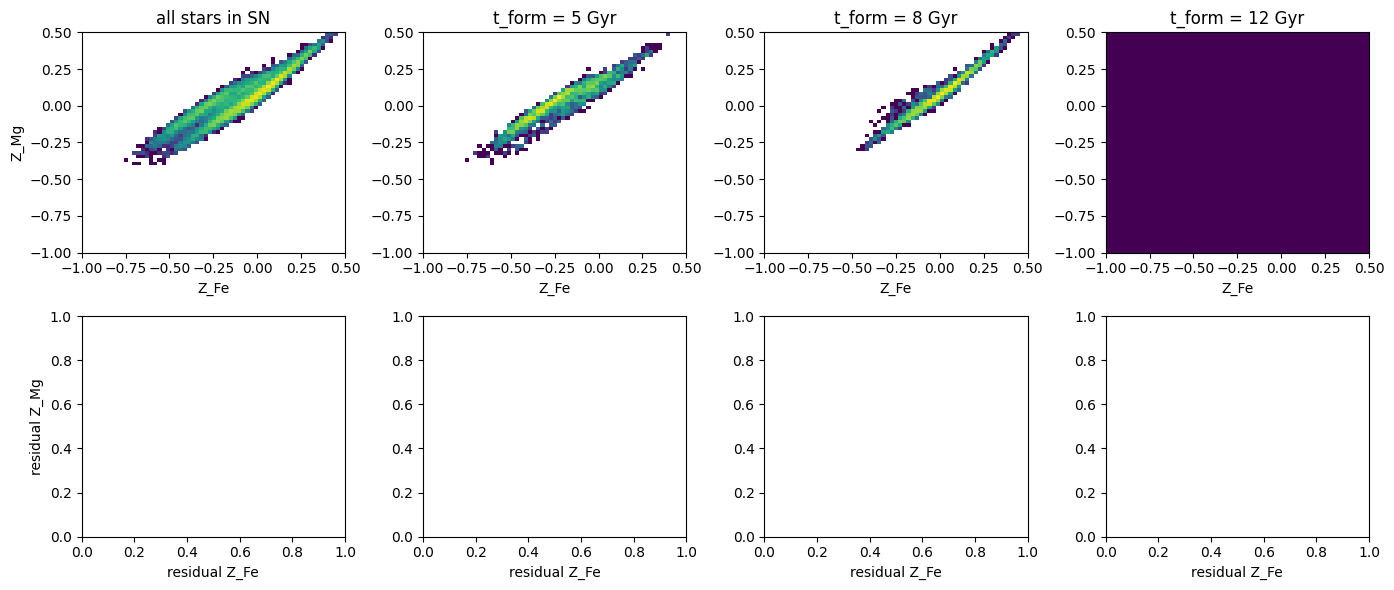

In [16]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(0, 2.5, 64)
MgH_bins = np.linspace(0, 2.5, 64)
logFeH_bins = np.linspace(-1, 0.5, 64)
logMgH_bins = np.linspace(-1, 0.5, 64)
resid_FeH_bins = np.linspace(-1, 1.5, 64)
resid_MgH_bins = np.linspace(-1, 1.5, 64)

aveFeH, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins, statistic='median')
aveMgH, _, _ = binned_statistic(t_form[in_SN], MgH[in_SN], bins=age_bins, statistic='median')
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins, statistic='median')
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFeH_interp = interp1d(aveage, aveFeH, bounds_error=False, fill_value='extrapolate')
aveMgH_interp = interp1d(aveage, aveMgH, bounds_error=False, fill_value='extrapolate')

aveFeH_pred = aveFeH_interp(t_form)
aveMgH_pred = aveMgH_interp(t_form)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))

resid_FeH = FeH - aveFeH_pred
resid_MgH = MgH - aveMgH_pred

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], 
                                              logMgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][0].set(aspect='auto', ylabel='Z_Mg', xlabel='Z_Fe')
ax[0][0].set_title('all stars in SN')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[in_SN], 
                                              resid_MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][0].set(aspect='auto', ylabel='residual Z_Mg', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][1].set(aspect='auto', xlabel='Z_Fe')
ax[0][1].set_title('t_form = 5 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][1].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][2].set(aspect='auto', xlabel='Z_Fe')
ax[0][2].set_title('t_form = 8 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][2].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][3].set(aspect='auto', xlabel='Z_Fe')
ax[0][3].set_title('t_form = 12 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][3].set(aspect='auto', xlabel='residual Z_Fe')

fig.tight_layout()

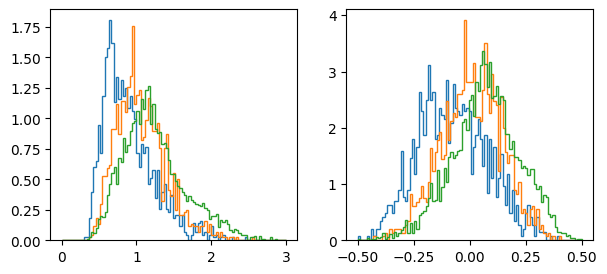

In [14]:
density = True

bins = np.linspace(0, 3, 100)
logbins = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);


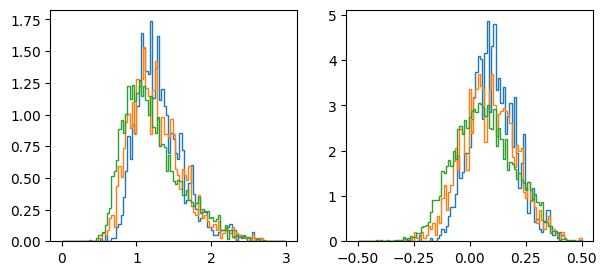

In [38]:
density = True

bins = np.linspace(0, 3, 100)
logbins = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);


In [15]:
from scipy.stats import multivariate_normal

In [17]:
multivariate_normal.fit?

Signature: multivariate_normal.fit(x, fix_mean=None, fix_cov=None)
Docstring:
Fit a multivariate normal distribution to data.

Parameters
----------
x : ndarray (m, n)
    Data the distribution is fitted to. Must have two axes.
    The first axis of length `m` represents the number of vectors
    the distribution is fitted to. The second axis of length `n`
    determines the dimensionality of the fitted distribution.
fix_mean : ndarray(n, )
    Fixed mean vector. Must have length `n`.
fix_cov: ndarray (n, n)
    Fixed covariance matrix. Must have shape `(n, n)`.

Returns
-------
mean : ndarray (n, )
    Maximum likelihood estimate of the mean vector
cov : ndarray (n, n)
    Maximum likelihood estimate of the covariance matrix
File:      ~/.conda/envs/note/lib/python3.10/site-packages/scipy/stats/_multivariate.py
Type:      method

In [102]:
t_min = 0
dt = 1.0

avet_form = []
mu = []
cov = []

while t_min < 13:
    key = np.logical_and(t_form > t_min, t_form < t_min + dt)
    key = np.logical_and(key, in_SN)
    
    avet_form.append(np.mean(t_form[key]))
    
    data = np.transpose([logFeH[key], logMgH[key]])
    mu_, cov_ = multivariate_normal.fit(data)
    mu.append(mu_)
    cov.append(cov_)

    t_min += dt/2.

avet_form = np.array(avet_form)
mu = np.array(mu)
cov = np.array(cov)

var = np.transpose([cov[:,0,0], cov[:,1,1]])
mu_Z = 10.**(mu + var/2.)
# mu_Z = mu

In [100]:
print(mu[-1])
print(var[-1])
print(mu_Z[-1])

[0.08443465 0.05044392]
[0.01675564 0.01602468]
[1.097256  1.0601985]


In [94]:
np.mean(10.**logFeH[key])

1.2696389

In [101]:
m = np.mean(logFeH[key])
s = np.std(logFeH[key])
print(m, s**2)
print(10.**(m + s**2/2.))

0.08443465 0.016755641923570153
1.238261790084175


In [30]:
print('mu.shape:', mu.shape)
print('cov.shape:', cov.shape)

mu.shape: (28, 2)
cov.shape: (28, 2, 2)


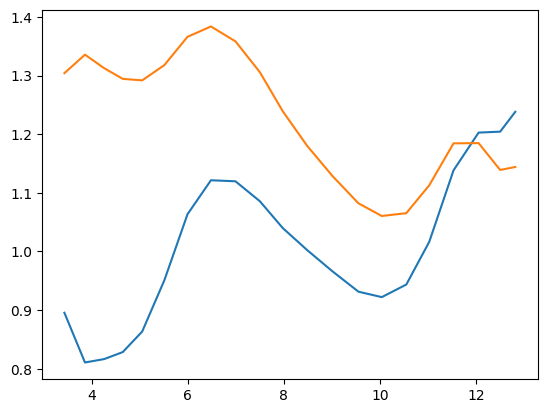

In [104]:
plt.plot(avet_form, mu_Z[:,0])
plt.plot(avet_form, mu_Z[:,1])
# plt.plot(avet_form, mu_Z[:,1]/mu_Z[:,0])

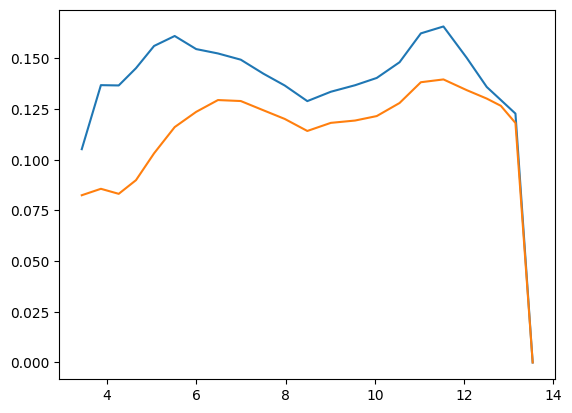

In [33]:
plt.plot(avet_form, np.sqrt(cov[:,0,0]))
plt.plot(avet_form, np.sqrt(cov[:,1,1]))

/tmp/ipykernel_3725236/835359177.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(avet_form, cov[:,0,1]/np.sqrt(cov[:,0,0]*cov[:,1,1]))


(0.0, 1.1)

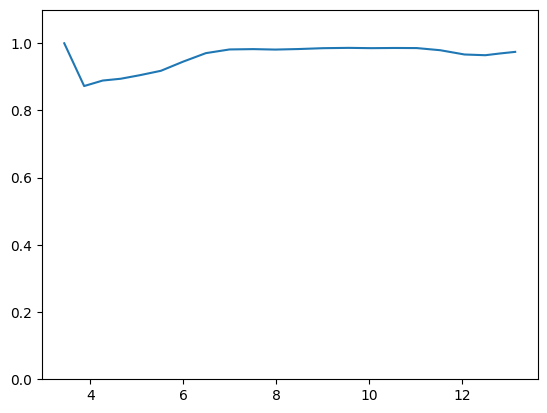

In [36]:
plt.plot(avet_form, cov[:,0,1]/np.sqrt(cov[:,0,0]*cov[:,1,1]))
plt.ylim(0, 1.1)

0.005706792312516639


/tmp/ipykernel_3672215/1837654704.py:3: RuntimeWarning: invalid value encountered in log10
  resid = np.log10(1+resid_MgH)


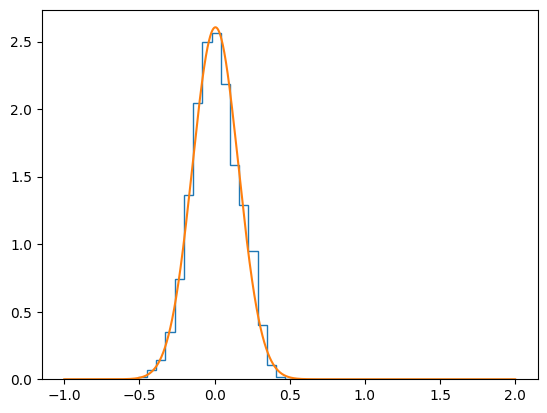

In [28]:
from scipy.stats import norm

resid = np.log10(1+resid_MgH)
# resid = resid_FeH

# key = np.logical_and(t_form > 4.5, t_form < 5.5)
# key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)

plt.hist(resid[key], histtype='step', bins=np.linspace(-1, 2, 50), density=True)

mu, sigma = norm.fit(resid[key])
print(mu)
xlist = np.linspace(-1, 2, 10000)
pdf = norm.pdf(xlist, mu, sigma)
plt.plot(xlist, pdf)

In [29]:
avet = []
aveFe = []
aveMgFe = []
avelogFe = []
avelogMgFe = []
tmin = 0.0
dt = 0.01

t_born = 13.813 - age

while tmin < 13.813:
    key = np.logical_and(t_born > tmin, t_born < tmin + 0.2)
    key = np.logical_and(key, in_SN)
    
    avet.append(np.mean(t_born[key]))
    aveFe.append(np.mean(10.**FeH[key]))
    aveMgFe.append(np.mean(10.**MgFe[key]))
    
    avelogFe.append(np.mean(FeH[key]))
    avelogMgFe.append(np.mean(MgFe[key]))
    
    tmin += dt

avet = np.array(avet)
aveFe = np.log10(np.array(aveFe))
aveMgFe = np.log10(np.array(aveMgFe))
avelogFe = np.array(avelogFe)
avelogMgFe = np.array(avelogMgFe)

/n/home01/abeane/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home01/abeane/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/n/home01/abeane/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '[Mg/Fe]')

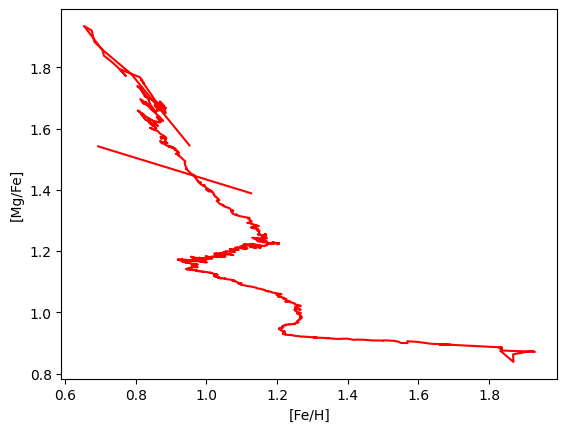

In [36]:
FeH_bins  = np.linspace(-1, 0.5, 100)
MgFe_bins = np.linspace(-0.2, 0.4, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[FeH_bins, MgFe_bins])

# plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

plt.plot(avelogFe, avelogMgFe, c='r')

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

In [38]:
np.where(mbin < 0)[0]

array([], dtype=int64)

Text(0, 0.5, 'Z_Mg/Z_Fe')

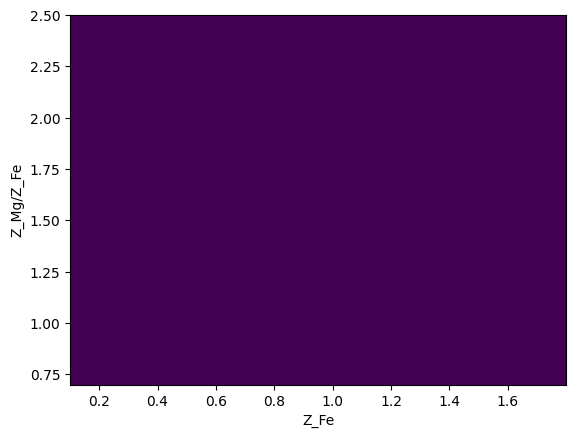

In [31]:
# FeH_bins  = np.linspace(-1, 0.5, 100)
# MgFe_bins = np.linspace(-0.2, 0.4, 100)
FeH_bins  = np.linspace(0.1, 1.8, 100)
MgFe_bins = np.linspace(0.7, 2.5, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(10.**FeH[in_SN], 10.**MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[FeH_bins, MgFe_bins])

plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

# plt.plot(10.**aveFe, 10.**aveMgFe, c='r')

plt.xlabel('Z_Fe')
plt.ylabel('Z_Mg/Z_Fe')